In [212]:
import collections
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import shutil
import os
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import io
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()


Akshar Patel


In [179]:
columns = [['duration', 'continuous'], ['protocol_type', 'symbolic'], ['service', 'symbolic'], ['flag', 'symbolic'], ['src_bytes', 'continuous'], ['dst_bytes', 'continuous'], ['land', 'symbolic'], ['wrong_fragment', 'continuous'], ['urgent', 'continuous'], ['hot', 'continuous'], ['num_failed_logins', 'continuous'], ['logged_in', 'symbolic'], ['num_compromised', 'continuous'], ['root_shell', 'continuous'], ['su_attempted', 'continuous'], ['num_root', 'continuous'], ['num_file_creations', 'continuous'], ['num_shells', 'continuous'], ['num_access_files', 'continuous'], ['num_outbound_cmds', 'continuous'], ['is_host_login', 'symbolic'], ['is_guest_login', 'symbolic'], ['count', 'continuous'], ['srv_count', 'continuous'], ['serror_rate', 'continuous'], ['srv_serror_rate', 'continuous'], ['rerror_rate', 'continuous'], ['srv_rerror_rate', 'continuous'], ['same_srv_rate', 'continuous'], ['diff_srv_rate', 'continuous'], ['srv_diff_host_rate', 'continuous'], ['dst_host_count', 'continuous'], ['dst_host_srv_count', 'continuous'], ['dst_host_same_srv_rate', 'continuous'], ['dst_host_diff_srv_rate', 'continuous'], ['dst_host_same_src_port_rate', 'continuous'], ['dst_host_srv_diff_host_rate', 'continuous'], ['dst_host_serror_rate', 'continuous'], ['dst_host_srv_serror_rate', 'continuous'], ['dst_host_rerror_rate', 'continuous'], ['dst_host_srv_rerror_rate', 'continuous'], ['outcome', 'symbolic']]
#categorical Cols
cols = list(map(lambda col: col[0], columns))
ccols = list(map(lambda col: col[0], filter(lambda col: col[1] == "symbolic", columns)))
ccols.pop()
#numeric Cols
ncols = list(map(lambda col: col[0], filter(lambda col: col[1] == "continuous", columns)))
print("Categorical Cols:", ccols)
print("Numerical Cols: ", ncols)

Categorical Cols: ['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login']
Numerical Cols:  ['duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']


# Data PreProcessing

In [180]:
#read data
df = pd.read_csv("network_intrusion_data.csv", header =  None)
df.columns = cols
print(df.shape)
df.head()

(494021, 42)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [181]:
print(df.isna().any(axis = 1).any())

False


In [182]:
print(df.isnull().any(axis = 1).any())
df.dropna(inplace = True)
print(df.shape)

False
(494021, 42)


Looks like no records with missing values

In [183]:
print("Before removing duplicated records:", df.shape)
df.drop_duplicates(inplace = True)
print("After removing duplicated records:", df.shape)
df.head()

Before removing duplicated records: (494021, 42)
After removing duplicated records: (145586, 42)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [184]:
print("Encoding outcome and dropping it")
df['enc_outcome'] = list(map(lambda x: 1 if x.strip().strip(".") != "normal" else 0, df.outcome))
df.drop("outcome", 1, inplace = True)
df.head()

Encoding outcome and dropping it


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,enc_outcome
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,0
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0


In [185]:
#Encode categorical using one-hot encoding
for categoricalCol in ccols:
    encode_text_dummy(df, categoricalCol)
print("After one hot encoding categorical cols:")
print(df.shape)
df.head()

After one hot encoding categorical cols:
(145586, 122)


,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,flag-S3,flag-SF,flag-SH,land-0,land-1,logged_in-0,logged_in-1,is_host_login-0,is_guest_login-0,is_guest_login-1
0,0,181,5450,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,1,1,0
1,0,239,486,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,1,1,0
2,0,235,1337,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,1,1,0
3,0,219,1337,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,1,1,0
4,0,217,2032,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,1,1,0


In [186]:
#Normalizing numeric cols
print("Before normalizing numeric cols:")
print(df[ncols])
for col in ncols:
    encode_numeric_zscore(df, col)
print("After normalizing numeric cols:")
print(df[ncols])

Before normalizing numeric cols:
        duration  src_bytes  dst_bytes  wrong_fragment  urgent  hot  \
0              0        181       5450               0       0    0   
1              0        239        486               0       0    0   
2              0        235       1337               0       0    0   
3              0        219       1337               0       0    0   
4              0        217       2032               0       0    0   
...          ...        ...        ...             ...     ...  ...   
494016         0        310       1881               0       0    0   
494017         0        282       2286               0       0    0   
494018         0        203       1200               0       0    0   
494019         0        291       1200               0       0    0   
494020         0        219       1234               0       0    0   

        num_failed_logins  num_compromised  root_shell  su_attempted  ...  \
0                       0            

In [187]:
df.isna()
missingCols = df.isna().any(axis = 0)
missingCols = missingCols[missingCols == True]
print(missingCols.index)
df.drop(columns = missingCols.index, inplace = True)
print(df.columns)

Index(['num_outbound_cmds'], dtype='object')
Index(['duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'num_compromised', 'root_shell', 'su_attempted',
       ...
       'flag-S3', 'flag-SF', 'flag-SH', 'land-0', 'land-1', 'logged_in-0',
       'logged_in-1', 'is_host_login-0', 'is_guest_login-0',
       'is_guest_login-1'],
      dtype='object', length=121)


In [188]:
encoded_outcomes = df.enc_outcome

In [189]:
x, y = to_xy(df, "enc_outcome")
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.2, random_state = 42)
outcomes = encode_text_index(df, "enc_outcome")
print(xtrain.shape)
print(xtest.shape)
print(ytrain.shape)
print(ytest.shape)
print(outcomes)


(116468, 120)
(29118, 120)
(116468, 2)
(29118, 2)
[0 1]


# Fully Connected Network Layer

In [190]:
checkpointer = ModelCheckpoint(filepath="./best_weights_fairclass.hdf5", verbose=0, save_best_only=True)
for i in range(5):
    model = Sequential()
    model.add(Dense(64, input_dim = xtrain.shape[1], activation = 'sigmoid'))
    model.add(Dense(25, activation = 'sigmoid'))
    model.add(Dense(30, activation = 'sigmoid'))
    model.add(Dense(ytrain.shape[1], activation = 'softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor = 'val_loss', patience = 5, min_delta = 1e-3, verbose = 1, mode = 'auto')
    model.fit(xtrain, ytrain, validation_data = (xtest, ytest), callbacks = [monitor, checkpointer], verbose = 2, epochs = 100)


Train on 116468 samples, validate on 29118 samples
Epoch 1/100
 - 11s - loss: 0.0513 - val_loss: 0.0144
Epoch 2/100
 - 10s - loss: 0.0141 - val_loss: 0.0090
Epoch 3/100
 - 10s - loss: 0.0117 - val_loss: 0.0079
Epoch 4/100
 - 10s - loss: 0.0109 - val_loss: 0.0069
Epoch 5/100
 - 11s - loss: 0.0099 - val_loss: 0.0089
Epoch 6/100
 - 10s - loss: 0.0089 - val_loss: 0.0068
Epoch 7/100
 - 10s - loss: 0.0081 - val_loss: 0.0055
Epoch 8/100
 - 10s - loss: 0.0072 - val_loss: 0.0055
Epoch 9/100
 - 10s - loss: 0.0067 - val_loss: 0.0057
Epoch 10/100
 - 10s - loss: 0.0061 - val_loss: 0.0048
Epoch 11/100
 - 11s - loss: 0.0060 - val_loss: 0.0047
Epoch 12/100
 - 10s - loss: 0.0055 - val_loss: 0.0045
Epoch 13/100
 - 10s - loss: 0.0052 - val_loss: 0.0046
Epoch 14/100
 - 10s - loss: 0.0051 - val_loss: 0.0043
Epoch 15/100
 - 10s - loss: 0.0048 - val_loss: 0.0049
Epoch 16/100
 - 10s - loss: 0.0047 - val_loss: 0.0042
Epoch 17/100
 - 10s - loss: 0.0046 - val_loss: 0.0046
Epoch 00017: early stopping
Train on 116

In [191]:
model.load_weights('./best_weights_fairclass.hdf5')
predictions = model.predict(xtest)
predictions = np.argmax(predictions, axis = 1)
groundY = np.argmax(ytest, axis = 1)
accuracyScore = metrics.accuracy_score(groundY, predictions)
print("Accuracy score:", accuracyScore)

Accuracy score: 0.9989697094580672


In [192]:
print(xtrain)

[[-0.10703298 -0.00368697 -0.04155219 ...  1.          1.
   0.        ]
 [-0.10784987 -0.00425388  0.06270733 ...  1.          1.
   0.        ]
 [-0.10784987 -0.00426542 -0.0298271  ...  1.          1.
   0.        ]
 ...
 [-0.10784987 -0.00439232 -0.04702828 ...  1.          1.
   0.        ]
 [-0.10784987 -0.00439232 -0.04702828 ...  1.          1.
   0.        ]
 [-0.10784987 -0.0039067  -0.04702828 ...  1.          1.
   0.        ]]


Confusion Matrix:
[[17600    10]
 [   20 11488]]


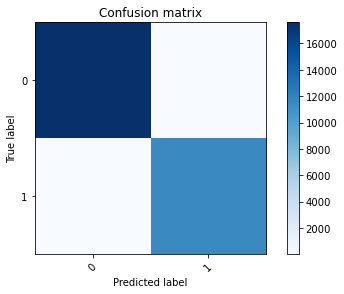

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17610
           1       1.00      1.00      1.00     11508

    accuracy                           1.00     29118
   macro avg       1.00      1.00      1.00     29118
weighted avg       1.00      1.00      1.00     29118

ROC:


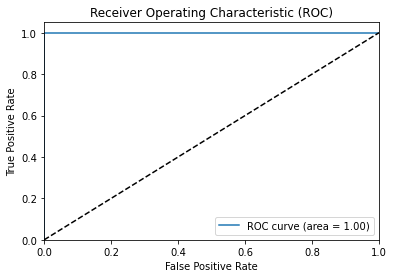

In [193]:
cm = metrics.confusion_matrix(groundY, predictions)
print("Confusion Matrix:")
print(cm)
plt.figure()
plot_confusion_matrix(cm, outcomes)
plt.show()
print(metrics.classification_report(groundY, predictions))
print("ROC:")
predictions = model.predict(xtest)
predictions = predictions[:, 1]
plot_roc(predictions, groundY)

# CNN

In [194]:
def preprocessForCNN():
    
    df.drop("enc_outcome", 1, inplace = True)
    xtrain, xtest, ytrain, ytest = train_test_split(df, encoded_outcomes, test_size = 0.2, random_state = 42)
    xtrain = xtrain.to_numpy()
    xtest = xtest.to_numpy()
    xtrainp = xtrain.reshape((xtrain.shape[0], 1, 120, 1))
    xtestp = xtest.reshape((xtest.shape[0], 1, 120, 1))
    ytrainp = keras.utils.to_categorical(ytrain, 2)
    ytestp = keras.utils.to_categorical(ytest, 2)
    return xtrainp, xtestp, ytrainp, ytestp
xtrainp, xtestp, ytrainp, ytestp = preprocessForCNN()


In [195]:
shape = (1, 120,1) 
batch = 64
checkpointer = ModelCheckpoint(filepath="./best_weights_fairclass1.hdf5", verbose=0, save_best_only=True) # save best model
for i in range(2):
    model = Sequential() 
    model.add(Conv2D(32, kernel_size = (1, 10), activation = 'relu', strides = (1, 1), padding = 'valid', input_shape = shape))
    model.add(Conv2D(64, kernel_size = (1, 10), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (1, 2), strides = None))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))
    model.summary()
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics = ['accuracy'])
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience =5, verbose=2, mode='auto')
    model.fit(xtrainp[0:10000], ytrainp[0:10000], validation_data = (xtestp, ytestp), epochs = 10, verbose = 2, batch_size = batch, callbacks = [monitor, checkpointer])
    

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 1, 111, 32)        352       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 1, 102, 64)        20544     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 1, 51, 64)         0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 1, 51, 64)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 3264)              0         
_________________________________________________________________
dense_161 (Dense)            (None, 128)               417920    
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)             

Accuracy: 0.9974586166632323
F1-score Averaged: 0.997458883817573
Confusing Matrix:
[[17566    44]
 [   30 11478]]


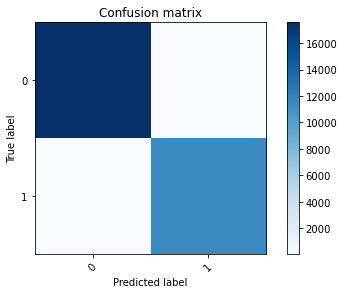

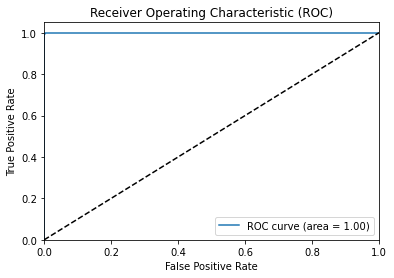

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17610
           1       1.00      1.00      1.00     11508

    accuracy                           1.00     29118
   macro avg       1.00      1.00      1.00     29118
weighted avg       1.00      1.00      1.00     29118



In [205]:
model.load_weights("./best_weights_fairclass1.hdf5")
pred = model.predict(xtestp)
true = np.argmax(ytestp, axis= 1)
pred = np.argmax(pred, axis = 1)
print("Accuracy:", metrics.accuracy_score(true, pred))
print("F1-score Averaged:", metrics.f1_score(true, pred, average = 'weighted'))
cm = metrics.confusion_matrix(true, pred)
print("Confusing Matrix:")
print(cm)
plot_confusion_matrix(cm, outcomes)
preds = model.predict(xtestp)
preds = preds[:, 1]
plot_roc(preds, true)
print(metrics.classification_report(true, pred))


# Hyper Tunning

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 1, 116, 32)        192       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 1, 112, 128)       20608     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 1, 37, 128)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 1, 37, 128)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 4736)              0         
_________________________________________________________________
dense_167 (Dense)            (None, 52)                246324    
_________________________________________________________________
dropout_21 (Dropout)         (None, 52)              

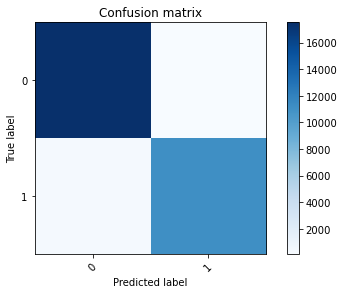

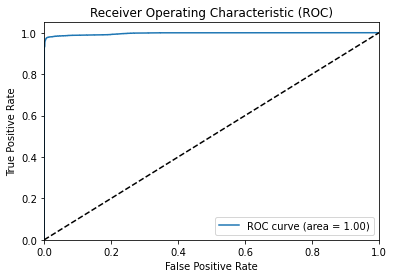

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     17610
           1       0.99      0.97      0.98     11508

    accuracy                           0.99     29118
   macro avg       0.99      0.98      0.98     29118
weighted avg       0.99      0.99      0.99     29118



In [207]:
shape = (1, 120,1) 
batch = 64
checkpointer = ModelCheckpoint(filepath="./best_weights_fairclass2.hdf5", verbose=0, save_best_only=True) # save best model
for i in range(2):
    model = Sequential() 
    model.add(Conv2D(32, kernel_size = (1, 5), activation = 'tanh', strides = (1, 1), padding = 'valid', input_shape = shape))
    model.add(Conv2D(128, kernel_size = (1, 5), activation = 'tanh'))
    model.add(MaxPooling2D(pool_size = (1, 3), strides = None))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(52, activation = 'tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))
    model.summary()
    model.compile(loss="categorical_crossentropy", optimizer="sgd", metrics = ['accuracy'])
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience =5, verbose=2, mode='auto')
    model.fit(xtrainp[0:10000], ytrainp[0:10000], validation_data = (xtestp[0:10000], ytestp[0:10000]), epochs = 10, verbose = 2, batch_size = batch, callbacks = [monitor, checkpointer])
model.load_weights("./best_weights_fairclass2.hdf5")
pred = model.predict(xtestp)
true = np.argmax(ytestp, axis= 1)
pred = np.argmax(pred, axis = 1)
print("Accuracy:", metrics.accuracy_score(true, pred))
print("F1-score Averaged:", metrics.f1_score(true, pred, average = 'weighted'))
cm = metrics.confusion_matrix(true, pred)
print("Confusing Matrix:")
print(cm)
plot_confusion_matrix(cm, outcomes)
preds = model.predict(xtestp)
preds = preds[:, 1]
plot_roc(preds, true)
print(metrics.classification_report(true, pred))

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 1, 114, 32)        256       
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 1, 108, 128)       28800     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 1, 36, 128)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 1, 36, 128)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 4608)              0         
_________________________________________________________________
dense_171 (Dense)            (None, 1024)              4719616   
_________________________________________________________________
dropout_25 (Dropout)         (None, 1024)            

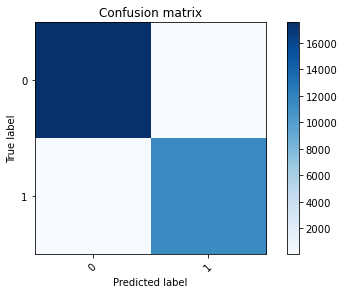

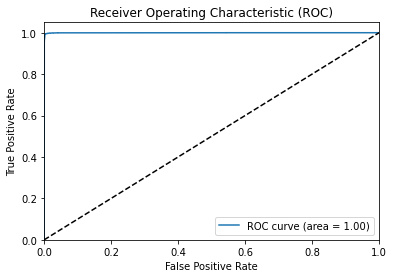

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17610
           1       0.99      0.99      0.99     11508

    accuracy                           1.00     29118
   macro avg       1.00      1.00      1.00     29118
weighted avg       1.00      1.00      1.00     29118



In [208]:
shape = (1, 120,1) 
batch = 128
checkpointer = ModelCheckpoint(filepath="./best_weights_fairclass3.hdf5", verbose=0, save_best_only=True) # save best model
for i in range(2):
    model = Sequential() 
    model.add(Conv2D(32, kernel_size = (1, 7), activation = 'relu', strides = (1, 1), padding = 'valid', input_shape = shape))
    model.add(Conv2D(128, kernel_size = (1, 7), activation = 'sigmoid'))
    model.add(MaxPooling2D(pool_size = (1, 3), strides = None))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1024, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))
    model.summary()
    model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics = ['accuracy'])
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience =5, verbose=2, mode='auto')
    model.fit(xtrainp[0:10000], ytrainp[0:10000], validation_data = (xtestp[0:10000], ytestp[0:10000]), epochs = 10, verbose = 2, batch_size = batch, callbacks = [monitor, checkpointer])
model.load_weights("./best_weights_fairclass3.hdf5")
pred = model.predict(xtestp)
true = np.argmax(ytestp, axis= 1)
pred = np.argmax(pred, axis = 1)
print("Accuracy:", metrics.accuracy_score(true, pred))
print("F1-score Averaged:", metrics.f1_score(true, pred, average = 'weighted'))
cm = metrics.confusion_matrix(true, pred)
print("Confusing Matrix:")
print(cm)
plot_confusion_matrix(cm, outcomes)
preds = model.predict(xtestp)
preds = preds[:, 1]
plot_roc(preds, true)
print(metrics.classification_report(true, pred))

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 1, 112, 32)        320       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 1, 104, 64)        18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 1, 34, 64)         0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 1, 34, 64)         0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 2176)              0         
_________________________________________________________________
dense_175 (Dense)            (None, 512)               1114624   
_________________________________________________________________
dropout_29 (Dropout)         (None, 512)             

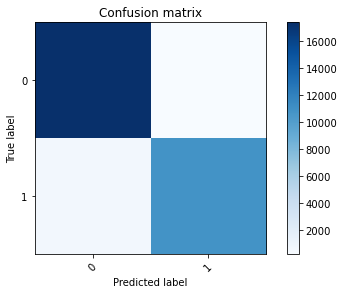

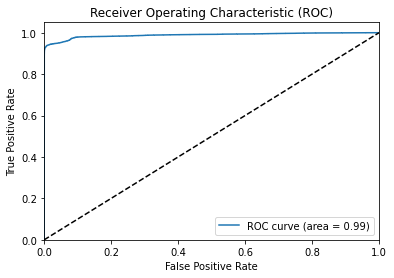

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     17610
           1       0.98      0.94      0.96     11508

    accuracy                           0.97     29118
   macro avg       0.97      0.96      0.97     29118
weighted avg       0.97      0.97      0.97     29118



In [209]:
shape = (1, 120,1) 
batch = 64
checkpointer = ModelCheckpoint(filepath="./best_weights_fairclass3.hdf5", verbose=0, save_best_only=True) # save best model
for i in range(2):
    model = Sequential() 
    model.add(Conv2D(32, kernel_size = (1, 9), activation = 'relu', strides = (1, 1), padding = 'valid', input_shape = shape))
    model.add(Conv2D(64, kernel_size = (1, 9), activation = 'tanh'))
    model.add(MaxPooling2D(pool_size = (1, 3), strides = None))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation = 'sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))
    model.summary()
    model.compile(loss="categorical_crossentropy", optimizer="sgd", metrics = ['accuracy'])
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience =5, verbose=2, mode='auto')
    model.fit(xtrainp[0:6000], ytrainp[0:6000], validation_data = (xtestp[0:6000], ytestp[0:6000]), epochs = 10, verbose = 2, batch_size = batch, callbacks = [monitor, checkpointer])
model.load_weights("./best_weights_fairclass3.hdf5")
pred = model.predict(xtestp)
true = np.argmax(ytestp, axis= 1)
pred = np.argmax(pred, axis = 1)
print("Accuracy:", metrics.accuracy_score(true, pred))
print("F1-score Averaged:", metrics.f1_score(true, pred, average = 'weighted'))
cm = metrics.confusion_matrix(true, pred)
print("Confusing Matrix:")
print(cm)
plot_confusion_matrix(cm, outcomes)
preds = model.predict(xtestp)
preds = preds[:, 1]
plot_roc(preds, true)
print(metrics.classification_report(true, pred))

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 1, 115, 128)       896       
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 1, 110, 256)       196864    
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 1, 36, 256)        0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 1, 36, 256)        0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 9216)              0         
_________________________________________________________________
dense_179 (Dense)            (None, 512)               4719104   
_________________________________________________________________
dropout_33 (Dropout)         (None, 512)             

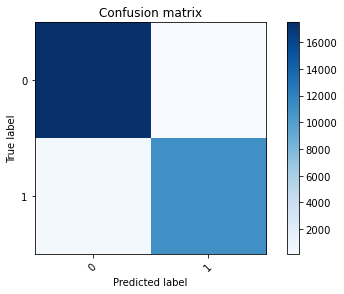

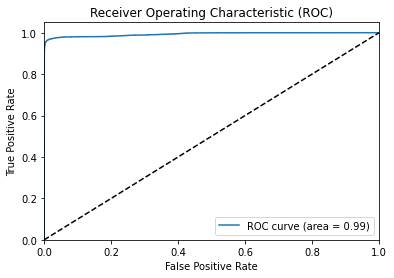

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     17610
           1       0.99      0.96      0.97     11508

    accuracy                           0.98     29118
   macro avg       0.98      0.98      0.98     29118
weighted avg       0.98      0.98      0.98     29118



In [210]:
shape = (1, 120,1) 
batch = 64
checkpointer = ModelCheckpoint(filepath="./best_weights_fairclass4.hdf5", verbose=0, save_best_only=True) # save best model
for i in range(2):
    model = Sequential() 
    model.add(Conv2D(128, kernel_size = (1, 6), activation = 'tanh', strides = (1, 1), padding = 'valid', input_shape = shape))
    model.add(Conv2D(256, kernel_size = (1, 6), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (1, 3), strides = None))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation = 'sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))
    model.summary()
    model.compile(loss="categorical_crossentropy", optimizer="sgd", metrics = ['accuracy'])
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience =5, verbose=2, mode='auto')
    model.fit(xtrainp[0:10000], ytrainp[0:10000], validation_data = (xtestp[0:10000], ytestp[0:10000]), epochs = 10, verbose = 2, batch_size = batch, callbacks = [monitor, checkpointer])
model.load_weights("./best_weights_fairclass4.hdf5")
pred = model.predict(xtestp)
true = np.argmax(ytestp, axis= 1)
pred = np.argmax(pred, axis = 1)
print("Accuracy:", metrics.accuracy_score(true, pred))
print("F1-score Averaged:", metrics.f1_score(true, pred, average = 'weighted'))
cm = metrics.confusion_matrix(true, pred)
print("Confusing Matrix:")
print(cm)
plot_confusion_matrix(cm, outcomes)
preds = model.predict(xtestp)
preds = preds[:, 1]
plot_roc(preds, true)
print(metrics.classification_report(true, pred))